### Определения и пояснения отдельных показателей

In [298]:
# strike price — цена, установленная в опционе, по которой покупатель опциона может купить 
# (при опционе колл) или продать (при опционе пут) базовый актив по действующему опциону, 
# а продавец опциона соответственно обязан продать или купить соответствующее количество базового актива.

# Trading Volume refers to the number of trades completed each day and is an important measure 
# of strength and interest in a particular trade. 

# Open interest reflects the number of contracts that are held by traders
# and investors in active positions, ready to be traded.

### Вспомогательные ссылки

In [299]:
# !pip install yahoo_fin
# !pip install yoptions
# !pip install pandas_datareader
# pip install lightgbm
# !pip install --upgrade xlrd

In [300]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
import os
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [301]:
CFTC_futures_only = pd.read_csv('D:/Учёба/ВКР/Все файлы от 30.12.22/CFTC_futures_only.csv')
all_commodities = pd.read_csv('D:/Учёба/ВКР/Все файлы от 30.12.22/all_commodities_modified.csv') 

all_commodities.drop_duplicates(subset = all_commodities.columns, inplace = True)
CFTC_futures_only.drop_duplicates(subset = CFTC_futures_only.columns, inplace = True)

CFTC_futures_only.Report_Date_as_MM_DD_YYYY = pd.to_datetime(CFTC_futures_only.Report_Date_as_MM_DD_YYYY)
all_commodities.Date = pd.to_datetime(all_commodities.Date)
CFTC_futures_only.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = False, inplace = True)

# Выравниваем датафреймы CFTC и с Коммодитис
all_commodities = all_commodities.loc[all_commodities.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()]

In [303]:
# CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains('GOLD')].Market_and_Exchange_Names.unique()
# CFTC_futures_only[CFTC_futures_only.Market_and_Exchange_Names.str.contains('BRENT CRUDE OIL LAST DAY - NEW YORK MERCANTILE EXCHANGE')]

### Динамика базовых активов. Работать будем только с Gold_Futures, Brent_Oil_Futures

In [304]:
# Ищем все уникальные типы фьючерсов, содержащих слова Oil, Gold
print(all_commodities[all_commodities.ticker.str.contains('Oil')].ticker.unique(), '\n')
print(all_commodities[all_commodities.ticker.str.contains('Gold')].ticker.unique())

['Brent_Oil_Futures' 'Crude_Oil_WTI_Futures' 'Heating_Oil_Futures'
 'London_Gas_Oil_Futures' 'US_Soybean_Oil_Futures'] 

['Gold_Futures']


### Предобработка датафрейма с базовыми активами (Crude_oil, Gold)

In [305]:
all_commodities = all_commodities.applymap(lambda x: str(x).replace(',', ''))
all_commodities.drop(columns = ['Unnamed: 0'], inplace = True)
all_commodities.Date = pd.to_datetime(all_commodities.Date)
#
all_commodities.Price = all_commodities.Price.astype('float')
all_commodities.Open = all_commodities.Open.astype('float')
all_commodities.High = all_commodities.High.astype('float')
all_commodities.Low = all_commodities.Low.astype('float')
#
all_commodities.rename(columns = {'Vol.': 'Volume',
                               'Change %': 'growth_rate'}, inplace = True)
all_commodities.Volume.replace('nan', 0, inplace = True)
all_commodities.growth_rate = all_commodities.growth_rate.apply(lambda x: str(x).replace('%', ''))
all_commodities.ticker = all_commodities.ticker.apply(lambda x: str(x).replace('HistoricalData', '')) ####
#
all_commodities.Date = pd.to_datetime(all_commodities.Date) ####
all_commodities['year'] = all_commodities.Date.dt.year

In [306]:
def value_to_float(x):
    if type(x) == float or type(x) == int:
        return x
    
    if 'K' in x:
        if len(x) > 1:
            return float(x.replace('K', '')) * 10
        return 1000.0
    
    if 'M' in x:
        if len(x) > 1:
            return float(x.replace('M', '')) * 10000
        return 1000000.0
    
    if 'B' in x:
        return float(x.replace('B', '')) * 10000000
    return 0.0

all_commodities.growth_rate = all_commodities.growth_rate.apply(lambda x: float(x))
all_commodities.Volume = all_commodities.Volume.apply(value_to_float)

### Отсекаем данные, начиная с 2006 года

In [343]:
gold = all_commodities.query('ticker == "Gold_Futures" & year >= 2006')
print(gold.shape)
# gold.tail()

(2977, 9)


In [344]:
Oil = all_commodities.query('ticker == "Brent_Oil_Futures" & year >= 2006')
print(Oil.shape)
# Oil.head()

(2956, 9)


In [362]:
Oil2 = all_commodities.query('ticker == "Crude_Oil_WTI_Futures" & year >= 2006')

Oil2 = Oil2.loc[Oil2.Date.isin(list(shell.Date))]
Oil2_before2016 = Oil2.query('Date <= "2016-01-01"')
Oil2_after2016 = Oil2.query('Date > "2016-01-01"')

### Stocks

In [366]:
shell = pd.read_csv('D:/Учёба/ВКР/Все файлы от 30.12.22/Фондовый рынок/SHELL_oil.csv') 
exxon = pd.read_csv('D:/Учёба/ВКР/Все файлы от 30.12.22/Фондовый рынок/exxon_oil.csv')
barrickgold = pd.read_csv('D:/Учёба/ВКР/Все файлы от 30.12.22/Фондовый рынок/barrickgold.csv')
newportgold = pd.read_csv('D:/Учёба/ВКР/Все файлы от 30.12.22/Фондовый рынок/newport_gold.csv')

shell.rename(columns = {'Vol.': 'Volume',
                               'Изм. %': 'growth_rate'}, inplace = True)
exxon.columns = list(shell.columns)
barrickgold.columns = list(shell.columns)
newportgold.columns = list(shell.columns)

barrickgold.Date = pd.to_datetime(barrickgold.Date).dt.strftime('%Y-%m-%d')
newportgold.Date = pd.to_datetime(newportgold.Date).dt.strftime('%Y-%m-%d')

shell[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = shell[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']].applymap(lambda x: str(x).replace(',', '.'))
exxon[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = exxon[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']].applymap(lambda x: str(x).replace(',', '.'))
barrickgold[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = barrickgold[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']].applymap(lambda x: str(x).replace(',', '.'))
newportgold[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']] = newportgold[['Date', 'Price', 'Open', 'High', 'Low', 'Change %']].applymap(lambda x: str(x).replace(',', '.'))

shell.Volume = shell.Volume.apply(lambda x: str(x).replace(',', ''))
exxon.Volume = exxon.Volume.apply(lambda x: str(x).replace(',', ''))
barrickgold.Volume = barrickgold.Volume.apply(lambda x: str(x).replace(',', ''))
newportgold.Volume = newportgold.Volume.apply(lambda x: str(x).replace(',', ''))

newportgold.Volume = newportgold.Volume.apply(value_to_float).astype('int')
barrickgold.Volume = barrickgold.Volume.apply(value_to_float).astype('int')
exxon.Volume = exxon.Volume.apply(value_to_float).astype('int')
shell.Volume = shell.Volume.apply(value_to_float).astype('int')

newportgold.Date = pd.to_datetime(newportgold.Date, dayfirst=False)
barrickgold.Date = pd.to_datetime(barrickgold.Date, dayfirst=False)
exxon.Date = pd.to_datetime(exxon.Date, dayfirst=False)
shell.Date = pd.to_datetime(shell.Date, dayfirst=False)

exxon = exxon.loc[(exxon.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (exxon.Date <= Oil.Date.max())]
shell = shell.loc[(shell.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (shell.Date <= Oil.Date.max())]

shell = shell.loc[shell.Date.isin(list(exxon.Date))]
exxon = exxon.loc[exxon.Date.isin(list(shell.Date))]

shell = shell.query('Date >= "2010-01-05"')
exxon = exxon.query('Date >= "2010-01-05"')
Oil = Oil.loc[Oil.Date.isin(list(shell.Date))]

newportgold = newportgold.loc[(newportgold.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (newportgold.Date <= gold.Date.max())]
barrickgold = barrickgold.loc[(barrickgold.Date >= CFTC_futures_only.Report_Date_as_MM_DD_YYYY.min()) & (barrickgold.Date <= gold.Date.max())]
gold = gold.loc[gold.Date.isin(list(barrickgold.Date))]

exxon.Price = exxon.Price.apply(lambda x: float(x))
shell.Price = shell.Price.apply(lambda x: float(x))
barrickgold.Price = barrickgold.Price.apply(lambda x: float(x))
newportgold.Price = newportgold.Price.apply(lambda x: float(x))

print('Newport gold: Размер выборки: ', newportgold.shape, '// Столбцы: ', list(newportgold.columns), '\n')
print('Barrick gold: Размер выборки: ', barrickgold.shape, '// Столбцы: ', list(barrickgold.columns), '\n')
print('Exxon: Размер выборки: ', exxon.shape, '// Столбцы: ', list(exxon.columns), '\n')
print('Shell: Размер выборки: ', shell.shape, '// Столбцы: ', list(shell.columns), '\n')

Newport gold: Размер выборки:  (2903, 7) // Столбцы:  ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %'] 

Barrick gold: Размер выборки:  (2903, 7) // Столбцы:  ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %'] 

Exxon: Размер выборки:  (2855, 7) // Столбцы:  ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %'] 

Shell: Размер выборки:  (2855, 7) // Столбцы:  ['Date', 'Price', 'Open', 'High', 'Low', 'Volume', 'Change %'] 



In [369]:
exxon_before2016 = exxon.query('Date <= "2016-01-01"')
shell_before2016 = shell.query('Date <= "2016-01-01"')
Oil_before2016 = Oil.query('Date <= "2016-01-01"')
gold_before2016 = gold.query('Date <= "2016-01-01"')
barrickgold_before2016 = barrickgold.query('Date <= "2016-01-01"')
newportgold_before2016 = newportgold.query('Date <= "2016-01-01"')


exxon_after2016 = exxon.query('Date > "2016-01-01"')
shell_after2016 = shell.query('Date > "2016-01-01"')
Oil_after2016 = Oil.query('Date > "2016-01-01"')
gold_after2016 = gold.query('Date > "2016-01-01"')
barrickgold_after2016 = barrickgold.query('Date > "2016-01-01"')
newportgold_after2016 = newportgold.query('Date > "2016-01-01"')

### Нефть Brent

К. корреляции Пирсона акции Shell - фьючерс Brent_Oil: 0.278
К. корреляции Пирсона акции Exxomobil - фьючерс Brent_Oil: 0.369


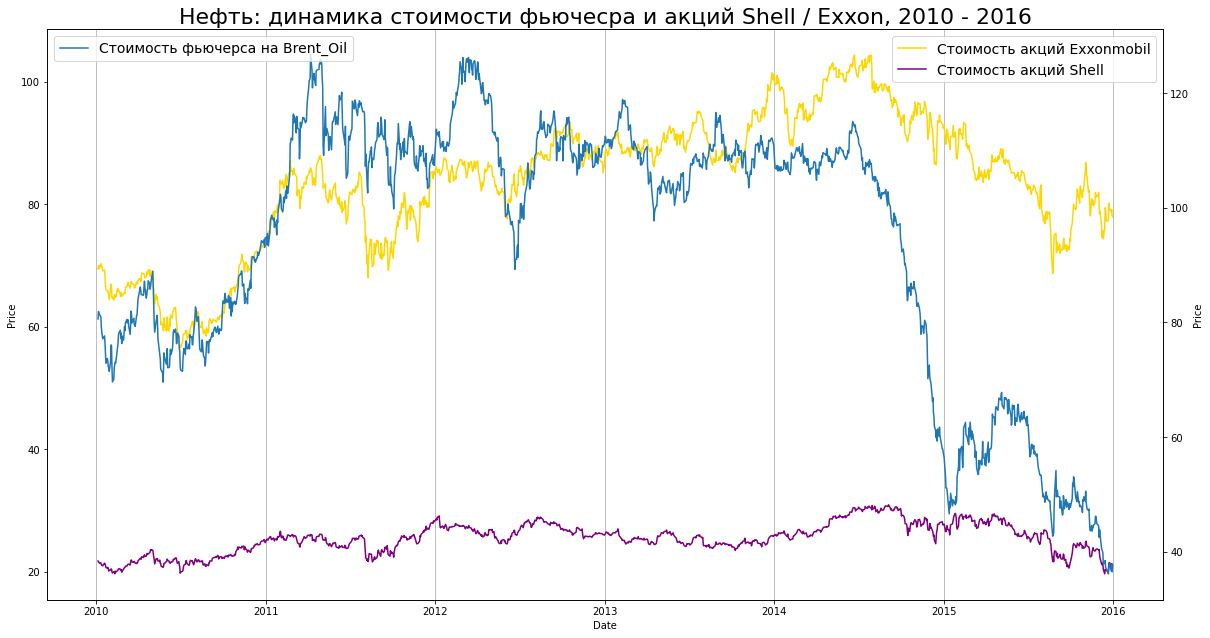

In [333]:
fig,ax = plt.subplots()

ss = sns.lineplot(data = exxon_before2016,
             y = exxon_before2016.Price,
             x = exxon_before2016.Date,
             color = 'gold',
             label = 'Стоимость акций Exxonmobil')

ss2 = sns.lineplot(data = shell_before2016,
             y = shell_before2016.Price,
             x = shell_before2016.Date,
             color = 'purple',
             label = 'Стоимость акций Shell')

ax2=ax.twinx() #вторая ось

ss3 = sns.lineplot(data = Oil_before2016,
             y = Oil_before2016.Price,
             x = Oil_before2016.Date,
             label = 'Стоимость фьючерса на Brent_Oil')

ax.grid(axis = 'x')
ax.legend(loc=0, fontsize = 14)
ax2.legend(loc=2, fontsize = 14)
# sns.move_legend(ss, "upper left", bbox_to_anchor=(1, 1))

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20, 10.5)

plt.title('Нефть: динамика стоимости фьючерса и акций Shell / Exxon, 2010 - 2016', fontsize = 22)
print('К. корреляции Пирсона акции Shell - фьючерс Brent_Oil:',
      round(np.corrcoef(shell_before2016.Price, Oil_before2016.Price)[0][1],3))

print('К. корреляции Пирсона акции Exxomobil - фьючерс Brent_Oil:',
      round(np.corrcoef(exxon_before2016.Price, Oil_before2016.Price)[0][1],3))

К. корреляции Пирсона акции Shell - фьючерс Brent_Oil: 0.672
К. корреляции Пирсона акции Exxomobil - фьючерс Brent_Oil: 0.36


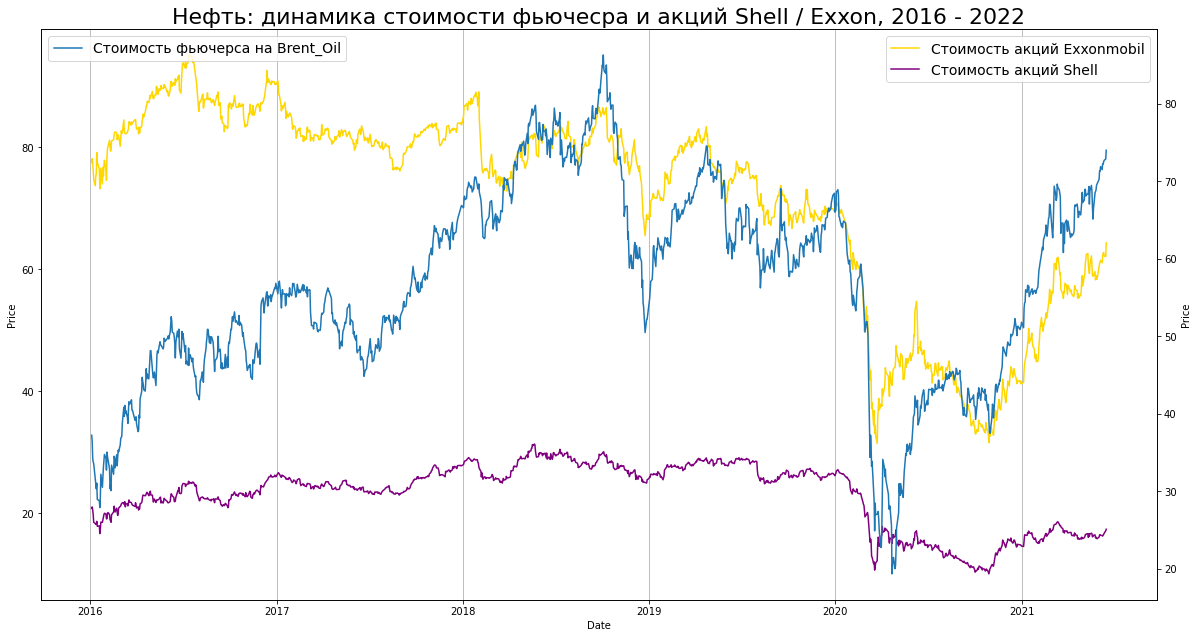

In [334]:
fig,ax = plt.subplots()

ss = sns.lineplot(data = exxon_after2016,
             y = exxon_after2016.Price,
             x = exxon_after2016.Date,
             color = 'gold',
             label = 'Стоимость акций Exxonmobil')

ss2 = sns.lineplot(data = shell_after2016,
             y = shell_after2016.Price,
             x = shell_after2016.Date,
             color = 'purple',
             label = 'Стоимость акций Shell')

ax2=ax.twinx() #вторая ось

ss3 = sns.lineplot(data = Oil_after2016,
             y = Oil_after2016.Price,
             x = Oil_after2016.Date,
             label = 'Стоимость фьючерса на Brent_Oil')

ax.grid(axis = 'x')
ax.legend(loc=0, fontsize = 14)
ax2.legend(loc=2, fontsize = 14)
# sns.move_legend(ss, "upper left", bbox_to_anchor=(1, 1))

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20, 10.5)

plt.title('Нефть: динамика стоимости фьючерса и акций Shell / Exxon, 2016 - 2022', fontsize = 22)

print('К. корреляции Пирсона акции Shell - фьючерс Brent_Oil:',
      round(np.corrcoef(shell_after2016.Price, Oil_after2016.Price)[0][1],3))

print('К. корреляции Пирсона акции Exxomobil - фьючерс Brent_Oil:',
      round(np.corrcoef(exxon_after2016.Price, Oil_after2016.Price)[0][1],3))

### Золото 2010 - 2016

К. корреляции Пирсона акции Barrick - фьючерс на Золото: 0.612
К. корреляции Пирсона акции Newport - фьючерс на Золото: 0.615


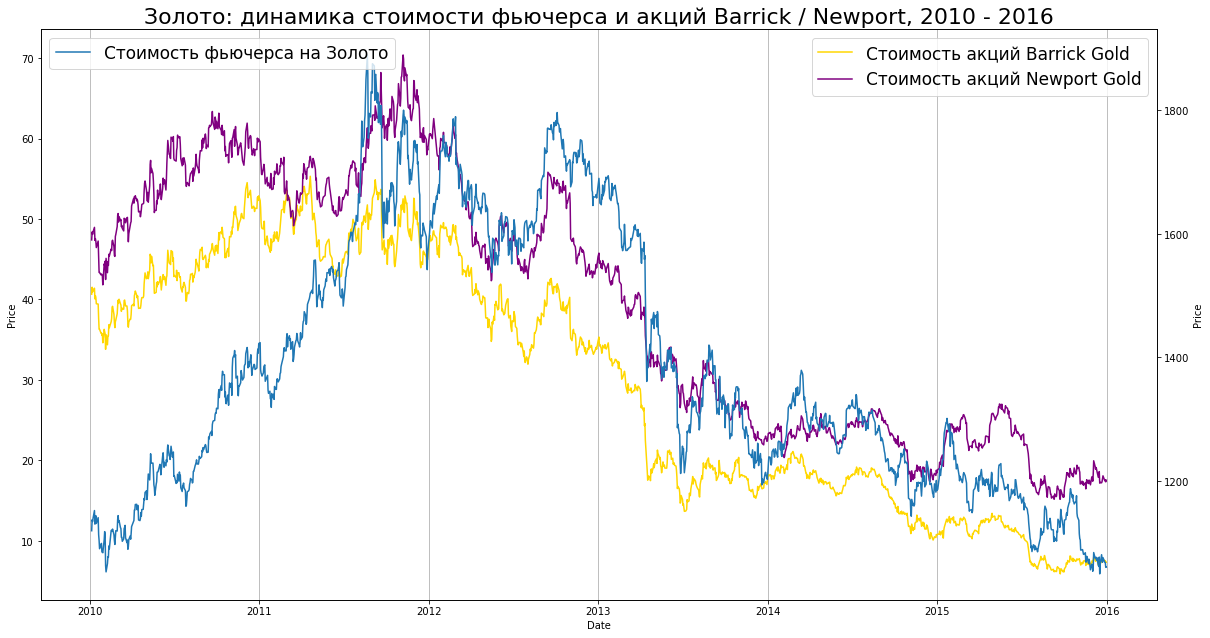

In [372]:
fig,ax = plt.subplots()

ss = sns.lineplot(data = barrickgold_before2016,
             y = barrickgold_before2016.Price,
             x = barrickgold_before2016.Date,
             color = 'gold',
             label = 'Стоимость акций Barrick Gold')

ss2 = sns.lineplot(data = newportgold_before2016,
             y = newportgold_before2016.Price,
             x = newportgold_before2016.Date,
             color = 'purple',
             label = 'Стоимость акций Newport Gold')


ax2=ax.twinx() #вторая ось

ss3 = sns.lineplot(data = gold_before2016,
             y = gold_before2016.Price,
             x = gold_before2016.Date,
             label = 'Стоимость фьючерса на Золото')

ax.grid(axis = 'x')
ax.legend(loc=0, fontsize = 17)
ax2.legend(loc=2, fontsize = 17)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20, 10.5)

plt.title('Золото: динамика стоимости фьючерса и акций Barrick / Newport, 2010 - 2016', fontsize = 22)

print('К. корреляции Пирсона акции Barrick - фьючерс на Золото:',
      round(np.corrcoef(barrickgold_before2016.Price, gold_before2016.Price)[0][1],3))

print('К. корреляции Пирсона акции Newport - фьючерс на Золото:',
      round(np.corrcoef(newportgold_before2016.Price, gold_before2016.Price)[0][1],3))


### Золото 2016 - 2021

К. корреляции Пирсона акции Barrick - фьючерс на Золото: 0.845
К. корреляции Пирсона акции Newport - фьючерс на Золото: 0.957


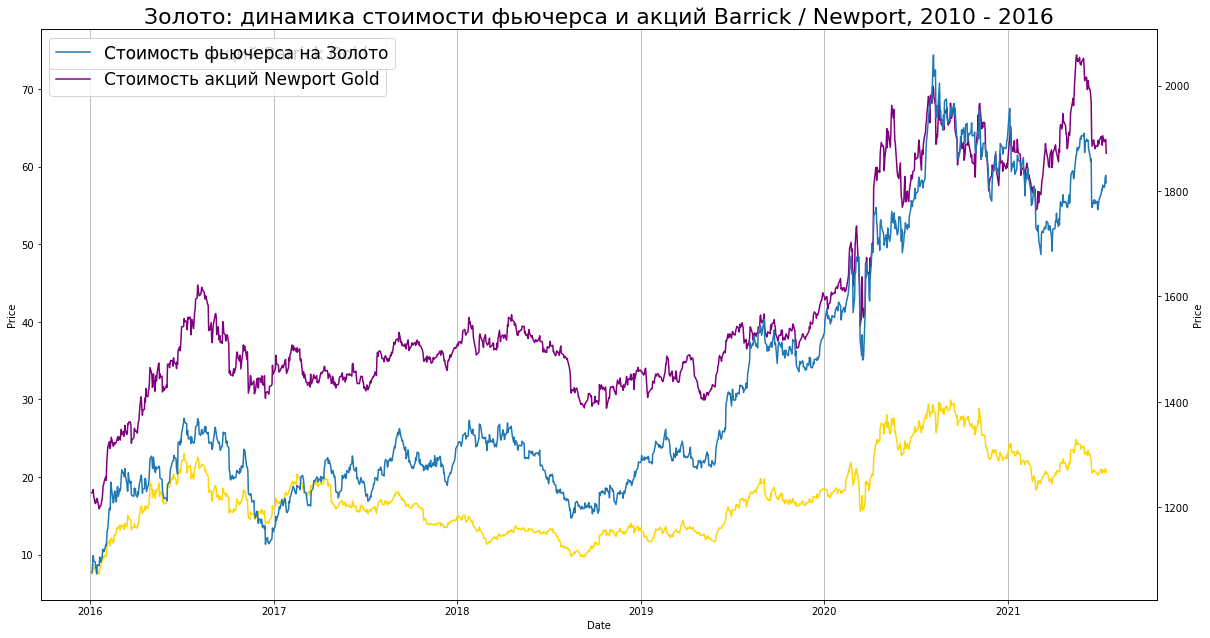

In [373]:
fig,ax = plt.subplots()

ss = sns.lineplot(data = barrickgold_after2016,
             y = barrickgold_after2016.Price,
             x = barrickgold_after2016.Date,
             color = 'gold',
             label = 'Стоимость акций Barrick Gold')

ss2 = sns.lineplot(data = newportgold_after2016,
             y = newportgold_after2016.Price,
             x = newportgold_after2016.Date,
             color = 'purple',
             label = 'Стоимость акций Newport Gold')


ax2=ax.twinx() #вторая ось

ss3 = sns.lineplot(data = gold_after2016,
             y = gold_after2016.Price,
             x = gold_after2016.Date,
             label = 'Стоимость фьючерса на Золото')

ax.grid(axis = 'x')
ax.legend(loc=0, fontsize = 17)
ax2.legend(loc=2, fontsize = 17)

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20, 10.5)

plt.title('Золото: динамика стоимости фьючерса и акций Barrick / Newport, 2016 - 2022', fontsize = 22)

print('К. корреляции Пирсона акции Barrick - фьючерс на Золото:',
      round(np.corrcoef(barrickgold_after2016.Price, gold_after2016.Price)[0][1],3))

print('К. корреляции Пирсона акции Newport - фьючерс на Золото:',
      round(np.corrcoef(newportgold_after2016.Price, gold_after2016.Price)[0][1],3))
